## Explainer notebook

**Motivation**

* What is your dataset?
* Why did you choose this/these particular dataset(s)?
* What was your goal for the end user’s experience?

This project concerns itself with our derived dataset containing artists from pop and rap culture within North America. As music plays a significant role for most peoples lives including our’s it was naturally intriguing for us to delve down the path of music as soon as it was an option. Ideas sparked, and the question `Do rap and pop culture collaborate differently? If so, how?` served as a catalyst for our exploration.

We wanted to figure out how the structures in the networks of rap and pop are constructed and differ. What makes a community within rap and pop. Do rap and pop communities differ and what does that say about culture?

Wee initially found a dataset containing ~156.000 artists and ~300.000 discovered collaborators between artist A and B, i.e. artist A and B has produced at least one song together. The choice of network graph was natural from this point as artists are naturally nodes and edges are 1 if artist A and B worked together 0 if they have not. However, this dataset contained artists from all over the world and of any size. Therefore we derived a subset, which is further explained in the data section, that contains only relevant artists in North America within rap and pop genres. From here we could dive in and do our analysis.



Large dataset:

`https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?resource=download&fbclid=IwZXh0bgNhZW0CMTEAAR5jxk4FClm9GBFvCklV4Ga5SRwON3ajfqLdOMjFqN1uereEEduffCtjEbkjJg_aem_YUf8t7fIjwbCWiHS_vrVc`

Top 10k most listened us artists dataset:

`https://www.kaggle.com/datasets/spoorthiuk/us-top-10k-artists-and-their-popular-songs`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import networkx as nx
import community as community_louvain
from collections import Counter, defaultdict
import netwulf as nw
import numpy as np

## Loading the datasets

In [2]:
nodes_df = pd.read_csv('nodes.csv')
edges_df = pd.read_csv('edges.csv')
nodes_df['genres'] = nodes_df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
nodes_df

spotify_id                name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4           Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK            Kontra K  1999676.0          72   
2       652XIvIBNGg3C0KIGEJWit               Maxim    34596.0          36   
3       3dXC1YPbnQPsfHPVkm1ipj  Christopher Martin   249233.0          52   
4       74terC9ol9zMo8rfzhSOiG       Jakob Hellman    21193.0          39   
...                        ...                 ...        ...         ...   
156417  2ces6d2YsQP1RpGMYpdFy8        David Urwitz     5470.0          29   
156418  6AeznZajNbXUulT7W4tK5l             Darmiko     2022.0          23   
156419  3GEijIjrgb4lPe9WtURBzz            Katriell      268.0           0   
156420  0ldQL0icSoMz9OOZcWG8Zt          Yung Fresh      181.0          19   
156421  1QZqarAGs0Lxx495oNcBnZ       Rakshitha Rao       23.0          24   

                                                   genres  \
0                              [nordic house, russelater]   
1                      [christlicher rap, german hip hop]   
2                                                      []   
3       [dancehall, lovers rock, modern reggae, reggae...   
4       [classic swedish pop, norrbotten indie, swedis...   
...                                                   ...   
156417                              [classic swedish pop]   
156418                                                 []   
156419                                                 []   
156420                                                 []   
156421                                                 []   

                                               chart_hits  
0                                              ['no (3)']  
1       ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
2                                              ['de (1)']  
3                                    ['at (1)', 'de (1)']  
4                                              ['se (6)']  
...                                                   ...  
156417                                                NaN  
156418                                                NaN  
156419                                                NaN  
156420                                                NaN  
156421                                                NaN  

[156422 rows x 6 columns]

In [3]:
artists_us_df = pd.read_csv("most_listened_artists_in_US_dataset.csv", index_col=0)
artists_us_df

ID  Gender  Age Country  \
Name                                                              
Drake               3TVXtAsR1Inumwj472S9r4    male   33      CA   
Post Malone         246dkjvS1zLTtiykXe5h60    male   25      US   
Ed Sheeran          6eUKZXaKkcviH0Ku9w2n3V    male   29      GB   
J Balvin            1vyhD5VmyZ7KMfW5gqLgo5    male   35      CO   
Bad Bunny           4q3ewBCX7sLwd24euuV69X    male   26      PR   
...                                    ...     ...  ...     ...   
IVAN$ITO            0cPmSFfjpop7imPVWSk2yc     NaN    0     NaN   
Antonello Venditti  3hYLJPJuDyblFKersEaFd6    male   71      IT   
Lea Salonga         1GlMjIezcLwV3OFlX0uXOv  female   49      PH   
Vertical Horizon    6Hizgjo92FnMp8wGaRUNTn   mixed   29     NaN   
Lakko               48wDYb8J9emrtnfRJvYEdZ    male    0      ES   

                                                               Genres  \
Name                                                                    
Drake               ['canadian hip hop', 'canadian pop', 'hip hop'...   
Post Malone                  ['dfw rap', 'melodic rap', 'pop', 'rap']   
Ed Sheeran                 ['pop', 'singer-songwriter pop', 'uk pop']   
J Balvin            ['reggaeton', 'reggaeton colombiano', 'trap la...   
Bad Bunny               ['reggaeton', 'trap latino', 'urbano latino']   
...                                                               ...   
IVAN$ITO                                                           []   
Antonello Venditti  ["canzone d'autore", 'classic italian pop', 'i...   
Lea Salonga                        ['movie tunes', 'tagalog worship']   
Vertical Horizon            ['neo mellow', 'pop rock', 'post-grunge']   
Lakko                                                              []   

                    Popularity  Followers  \
Name                                        
Drake                       95   83298497   
Post Malone                 86   43130108   
Ed Sheeran                  87  115998928   
J Balvin                    83   38028010   
Bad Bunny                   95   77931484   
...                        ...        ...   
IVAN$ITO                    20       4249   
Antonello Venditti          54     778642   
Lea Salonga                 56     179832   
Vertical Horizon            48     431277   
Lakko                       21      21571   

                                                      URI  
Name                                                       
Drake               spotify:artist:3TVXtAsR1Inumwj472S9r4  
Post Malone         spotify:artist:246dkjvS1zLTtiykXe5h60  
Ed Sheeran          spotify:artist:6eUKZXaKkcviH0Ku9w2n3V  
J Balvin            spotify:artist:1vyhD5VmyZ7KMfW5gqLgo5  
Bad Bunny           spotify:artist:4q3ewBCX7sLwd24euuV69X  
...                                                   ...  
IVAN$ITO            spotify:artist:0cPmSFfjpop7imPVWSk2yc  
Antonello Venditti  spotify:artist:3hYLJPJuDyblFKersEaFd6  
Lea Salonga         spotify:artist:1GlMjIezcLwV3OFlX0uXOv  
Vertical Horizon    spotify:artist:6Hizgjo92FnMp8wGaRUNTn  
Lakko               spotify:artist:48wDYb8J9emrtnfRJvYEdZ  

[9488 rows x 8 columns]

In [4]:
artists_us_name_list = (artists_us_df.index).tolist()
print(artists_us_name_list[:5])

['Drake', 'Post Malone', 'Ed Sheeran', 'J Balvin', 'Bad Bunny']


## Finding the intersection betwen the two datasets

We will now be constructing our dataset as a intersection between the large spotify collaration dataset and `artists_us_name_list`

In [5]:
nodes_df = nodes_df[nodes_df["name"].isin(artists_us_name_list)]
nodes_df

spotify_id           name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4      Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK       Kontra K  1999676.0          72   
15      3xs0LEzcPXtgNfMNcHzLIP       Rockwell    40344.0          58   
20      2NUz5P42WqkxilbI8ocN76    Vybz Kartel  1026598.0          63   
22      4Lm0pUvmisUHMdoky5ch2I   Apocalyptica   864846.0          60   
...                        ...            ...        ...         ...   
156038  7p5J8SfKU9Rulp7tcA53G8     Jose Merce   182186.0          51   
156119  3gJ0f9ov2Vjrbo9RnFFH76          Endor      267.0           2   
156199  7mKmqnXqn1WoEFljKyvAHR        2T FLOW       20.0          29   
156220  6kT18gnkVrCz8xJQcrib7L        Bhaskar   230894.0          60   
156330  0Wkm45quqfx3NepJpXDvwE  Superorganism   225468.0          51   

                                                   genres  \
0                              [nordic house, russelater]   
1                      [christlicher rap, german hip hop]   
15                                                     []   
20         [dancehall, jamaican dancehall, reggae fusion]   
22      [alternative metal, bow pop, cello, finnish me...   
...                                                   ...   
156038  [cante flamenco, flamenco, nuevo flamenco, rumba]   
156119                              [scottish indie folk]   
156199                                                 []   
156220   [brazilian bass, brazilian edm, brazilian house]   
156330                                          [art pop]   

                                               chart_hits  
0                                              ['no (3)']  
1       ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
15      ['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (...  
20                                   ['cr (3)', 'pa (1)']  
22                                             ['fi (2)']  
...                                                   ...  
156038                                                NaN  
156119                                                NaN  
156199                                                NaN  
156220                                                NaN  
156330                                                NaN  

[9754 rows x 6 columns]

By inspecting the dataframe, we notice there are more artists in the intersection than in the dataset containing the most listened artists in the US. This indicates there are duplicates in the dataset. We will inspect this:

In [6]:
duplicate_names = nodes_df[nodes_df.duplicated(subset="name", keep=False)].sort_values(by="name")

duplicate_names

spotify_id             name  followers  popularity  \
43592   1ItNxpDdetHb2gyS10HKfF         18 Karat     1644.0          18   
13282   5oWFxbBrbk2Mw86PLUg3OZ         18 Karat   292544.0          53   
57139   09ZUMxxU5pgzUF0FtHeGXG         19HUNNID        5.0           1   
59493   2Zm4abMQXwcrsM9IWY3AoB         19HUNNID      513.0          31   
156199  7mKmqnXqn1WoEFljKyvAHR          2T FLOW       20.0          29   
...                        ...              ...        ...         ...   
146823  1wEQjEpK6KfE9Et2ZZBfPa           Żabson       43.0           4   
24780   0FtUnl4AjR5eDa1v77WU0b  ปู่จ๋าน ลองไมค์      138.0          17   
95174   23YWwPEvaO5HLqEMgiUXJa  ปู่จ๋าน ลองไมค์    23424.0          32   
6081    3dTgjg7lzUGiD3NwcGCK1n               阿冗    44494.0          48   
8241    7sD5pBZNNSDMfiF2BvRem7               阿冗      671.0          31   

                                                   genres  \
43592                                                  []   
13282   [deep german hip hop, german hip hop, german u...   
57139                                                  []   
59493                                         [thai trap]   
156199                                                 []   
...                                                   ...   
146823                                                 []   
24780                                                  []   
95174                                                  []   
6081            [chinese viral pop, mainland chinese pop]   
8241                                                   []   

                                         chart_hits  
43592                                           NaN  
13282   ['at (16)', 'de (30)', 'lu (3)', 'ch (12)']  
57139                                           NaN  
59493                                           NaN  
156199                                          NaN  
...                                             ...  
146823                                          NaN  
24780                                           NaN  
95174                                           NaN  
6081                 ['my (1)', 'sg (1)', 'tw (4)']  
8241                                     ['tw (1)']  

[1739 rows x 6 columns]

As we can see, there are a large number of duplicate names. This is likely due to the size of the Spotify dataset, which contains more than 156,000 artists. Since artist names on Spotify are not unique, many small and therefore negligible artists are included in our dataframe. To address this, we will apply a simple algorithm: for duplicate names, we will keep only the artist with the most Spotify followers.

In [7]:
final_cleaned_nodes_df = nodes_df.sort_values("followers", ascending=False)
final_cleaned_nodes_df = nodes_df.drop_duplicates(subset="name", keep="first")
final_cleaned_nodes_df

spotify_id            name  followers  popularity  \
0       48WvrUGoijadXXCsGocwM4       Byklubben     1738.0          24   
1       4lDiJcOJ2GLCK6p9q5BgfK        Kontra K  1999676.0          72   
15      3xs0LEzcPXtgNfMNcHzLIP        Rockwell    40344.0          58   
20      2NUz5P42WqkxilbI8ocN76     Vybz Kartel  1026598.0          63   
22      4Lm0pUvmisUHMdoky5ch2I    Apocalyptica   864846.0          60   
...                        ...             ...        ...         ...   
155870  3a9qv6NLHnsVxJUtKOMHvD  The Glitch Mob   538974.0          61   
156036  7dh6G6qILmRpUtZU4ZSD4D        Trobeats      515.0           9   
156038  7p5J8SfKU9Rulp7tcA53G8      Jose Merce   182186.0          51   
156220  6kT18gnkVrCz8xJQcrib7L         Bhaskar   230894.0          60   
156330  0Wkm45quqfx3NepJpXDvwE   Superorganism   225468.0          51   

                                                   genres  \
0                              [nordic house, russelater]   
1                      [christlicher rap, german hip hop]   
15                                                     []   
20         [dancehall, jamaican dancehall, reggae fusion]   
22      [alternative metal, bow pop, cello, finnish me...   
...                                                   ...   
155870  [edm, electro house, glitch, glitch hop, indie...   
156036                                                 []   
156038  [cante flamenco, flamenco, nuevo flamenco, rumba]   
156220   [brazilian bass, brazilian edm, brazilian house]   
156330                                          [art pop]   

                                               chart_hits  
0                                              ['no (3)']  
1       ['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ...  
15      ['us (1)', 'gb (1)', 'at (1)', 'be (1)', 'ca (...  
20                                   ['cr (3)', 'pa (1)']  
22                                             ['fi (2)']  
...                                                   ...  
155870                                                NaN  
156036                                                NaN  
156038                                                NaN  
156220                                                NaN  
156330                                                NaN  

[8756 rows x 6 columns]

Now, as we can see the intersection contains only 8756 rows (before 9754), meaning we succesfully removed 998 duplicate artists with the least amount of followers. We have now reached our final desired dataset

## Functions for constructing the desired networks:

In [8]:
def split_artists_by_genre(nodes_df, genre_names, exclusive=False):    
    nodes_df = nodes_df.copy()

    filtered_dfs = []

    for genre in genre_names:
        if exclusive:
            other_genres = [g for g in genre_names if g != genre]
            
            df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres) and all(other not in ' '.join(genres) for other in other_genres)
                )
            ].copy()
        else:
             df = nodes_df[
                nodes_df['genres'].apply(
                    lambda genres: genre in ' '.join(genres)
                )
            ].copy()
        
        filtered_dfs.append(df)

    return filtered_dfs

def get_Graph_with_names(nodes_df, edges_df, verbose=True):
    nodes_df = nodes_df.dropna(subset=['spotify_id', 'name'])
    edges_df = edges_df.dropna(subset=['id_0', 'id_1'])

    # Build ID to name map
    id_to_name = dict(zip(nodes_df['spotify_id'], nodes_df['name']))
    allowed_ids = set(id_to_name.keys())

    # Create graph with artist names as nodes
    G = nx.Graph()

    for _, row in nodes_df.iterrows():
        artist_name = row['name']
        followers = row['followers'] if not pd.isna(row['followers']) else 0
        popularity = row['popularity'] if not pd.isna(row['popularity']) else 0
        genres = row['genres']
        chart_hits = row['chart_hits'] if not pd.isna(row['chart_hits']) else []

        G.add_node(artist_name, followers=followers, popularity=popularity,
                   genres=genres, chart_hits=chart_hits)

    for _, row in edges_df.iterrows():
        id_0, id_1 = row['id_0'], row['id_1']
        if id_0 in allowed_ids and id_1 in allowed_ids:
            name_0 = id_to_name.get(id_0)
            name_1 = id_to_name.get(id_1)
            if name_0 and name_1:
                G.add_edge(name_0, name_1)

    if verbose:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G)}")

    return G

def get_n_largest_component(G, n):
    return sorted(nx.connected_components(G), key=len, reverse=True)[n]

def apply_louvain(G, verbose=True):
    partition = community_louvain.best_partition(G)

    nx.set_node_attributes(G, partition, 'community')
    
    if verbose:
        community_sizes = Counter(partition.values())
        sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
        for community_id, size in sorted_communities:
            print(f"Community {community_id}: {size} nodes")
    
    communities = defaultdict(list)
    for node, community_id in partition.items():
        communities[community_id].append(node)
    
    sorted_communities = sorted(communities.items(), key=lambda x: len(x[1]), reverse=True)
    return sorted_communities
        
def get_community_subgraph(G, community_id):
    nodes_in_community = [n for n, attr in G.nodes(data=True) if attr.get('community') == community_id]
    
    subgraph = G.subgraph(nodes_in_community).copy()
    
    return subgraph

def get_combined_louvain_splitted_graph(G):
    _G = G.copy()
    partition = community_louvain.best_partition(_G)
    nx.set_node_attributes(_G, partition, 'community')

    combined_G = nx.Graph()
    
    combined_G.add_nodes_from(_G.nodes(data=True))

    for u, v in _G.edges():
        if partition[u] == partition[v]:
            combined_G.add_edge(u, v, **_G[u][v])

    return combined_G

def print_top_collaborators(G, n):
    top_collaborators = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]

    print(f"Top {n} artists with the most collaborations:")
    for rank, (artist, degree) in enumerate(top_collaborators, start=1):
        print(f"{rank}. {artist} — {degree} collaborations")


In [9]:
pop_df, rap_df = split_artists_by_genre(final_cleaned_nodes_df, ["pop", "rap"])

len(pop_df), len(rap_df)

(4398, 1704)

In [10]:
G_pop = get_Graph_with_names(pop_df, edges_df)
G_rap = get_Graph_with_names(rap_df, edges_df)

Number of nodes: 4398
Number of edges: 17648
Network density: 0.0018252140370625595
Number of nodes: 1704
Number of edges: 11704
Network density: 0.008066405873093326


In [11]:
print_top_collaborators(G_rap, 5)

Top 5 artists with the most collaborations:
1. Ty Dolla $ign — 133 collaborations
2. Gucci Mane — 128 collaborations
3. French Montana — 124 collaborations
4. Future — 116 collaborations
5. Lil Wayne — 113 collaborations


In [12]:
print(print_top_collaborators(G_pop, 5))

Top 5 artists with the most collaborations:
1. R3HAB — 165 collaborations
2. Ty Dolla $ign — 141 collaborations
3. David Guetta — 135 collaborations
4. Snoop Dogg — 123 collaborations
5. Steve Aoki — 117 collaborations
None


In [13]:
G_rap_splittet = get_combined_louvain_splitted_graph(G_rap)

In [14]:
communities = apply_louvain(G_rap)
largest_community_id = communities[0][0]

G_largest_rap_community = get_community_subgraph(G_rap, largest_community_id)
G_largest_rap_community_splitted = get_combined_louvain_splitted_graph(G_largest_rap_community)

Community 2: 458 nodes
Community 5: 256 nodes
Community 1: 140 nodes
Community 14: 123 nodes
Community 11: 122 nodes
Community 9: 98 nodes
Community 26: 91 nodes
Community 16: 66 nodes
Community 7: 56 nodes
Community 66: 27 nodes
Community 21: 26 nodes
Community 22: 20 nodes
Community 4: 18 nodes
Community 34: 17 nodes
Community 12: 5 nodes
Community 53: 5 nodes
Community 82: 4 nodes
Community 118: 4 nodes
Community 30: 3 nodes
Community 41: 3 nodes
Community 112: 3 nodes
Community 148: 3 nodes
Community 46: 2 nodes
Community 89: 2 nodes
Community 90: 2 nodes
Community 111: 2 nodes
Community 122: 2 nodes
Community 3: 1 nodes
Community 6: 1 nodes
Community 10: 1 nodes
Community 13: 1 nodes
Community 15: 1 nodes
Community 17: 1 nodes
Community 18: 1 nodes
Community 20: 1 nodes
Community 23: 1 nodes
Community 24: 1 nodes
Community 25: 1 nodes
Community 27: 1 nodes
Community 28: 1 nodes
Community 29: 1 nodes
Community 31: 1 nodes
Community 32: 1 nodes
Community 33: 1 nodes
Community 35: 1 

## Visualzing the networks with `Netwulf`

In [ ]:
# Visualize pop network


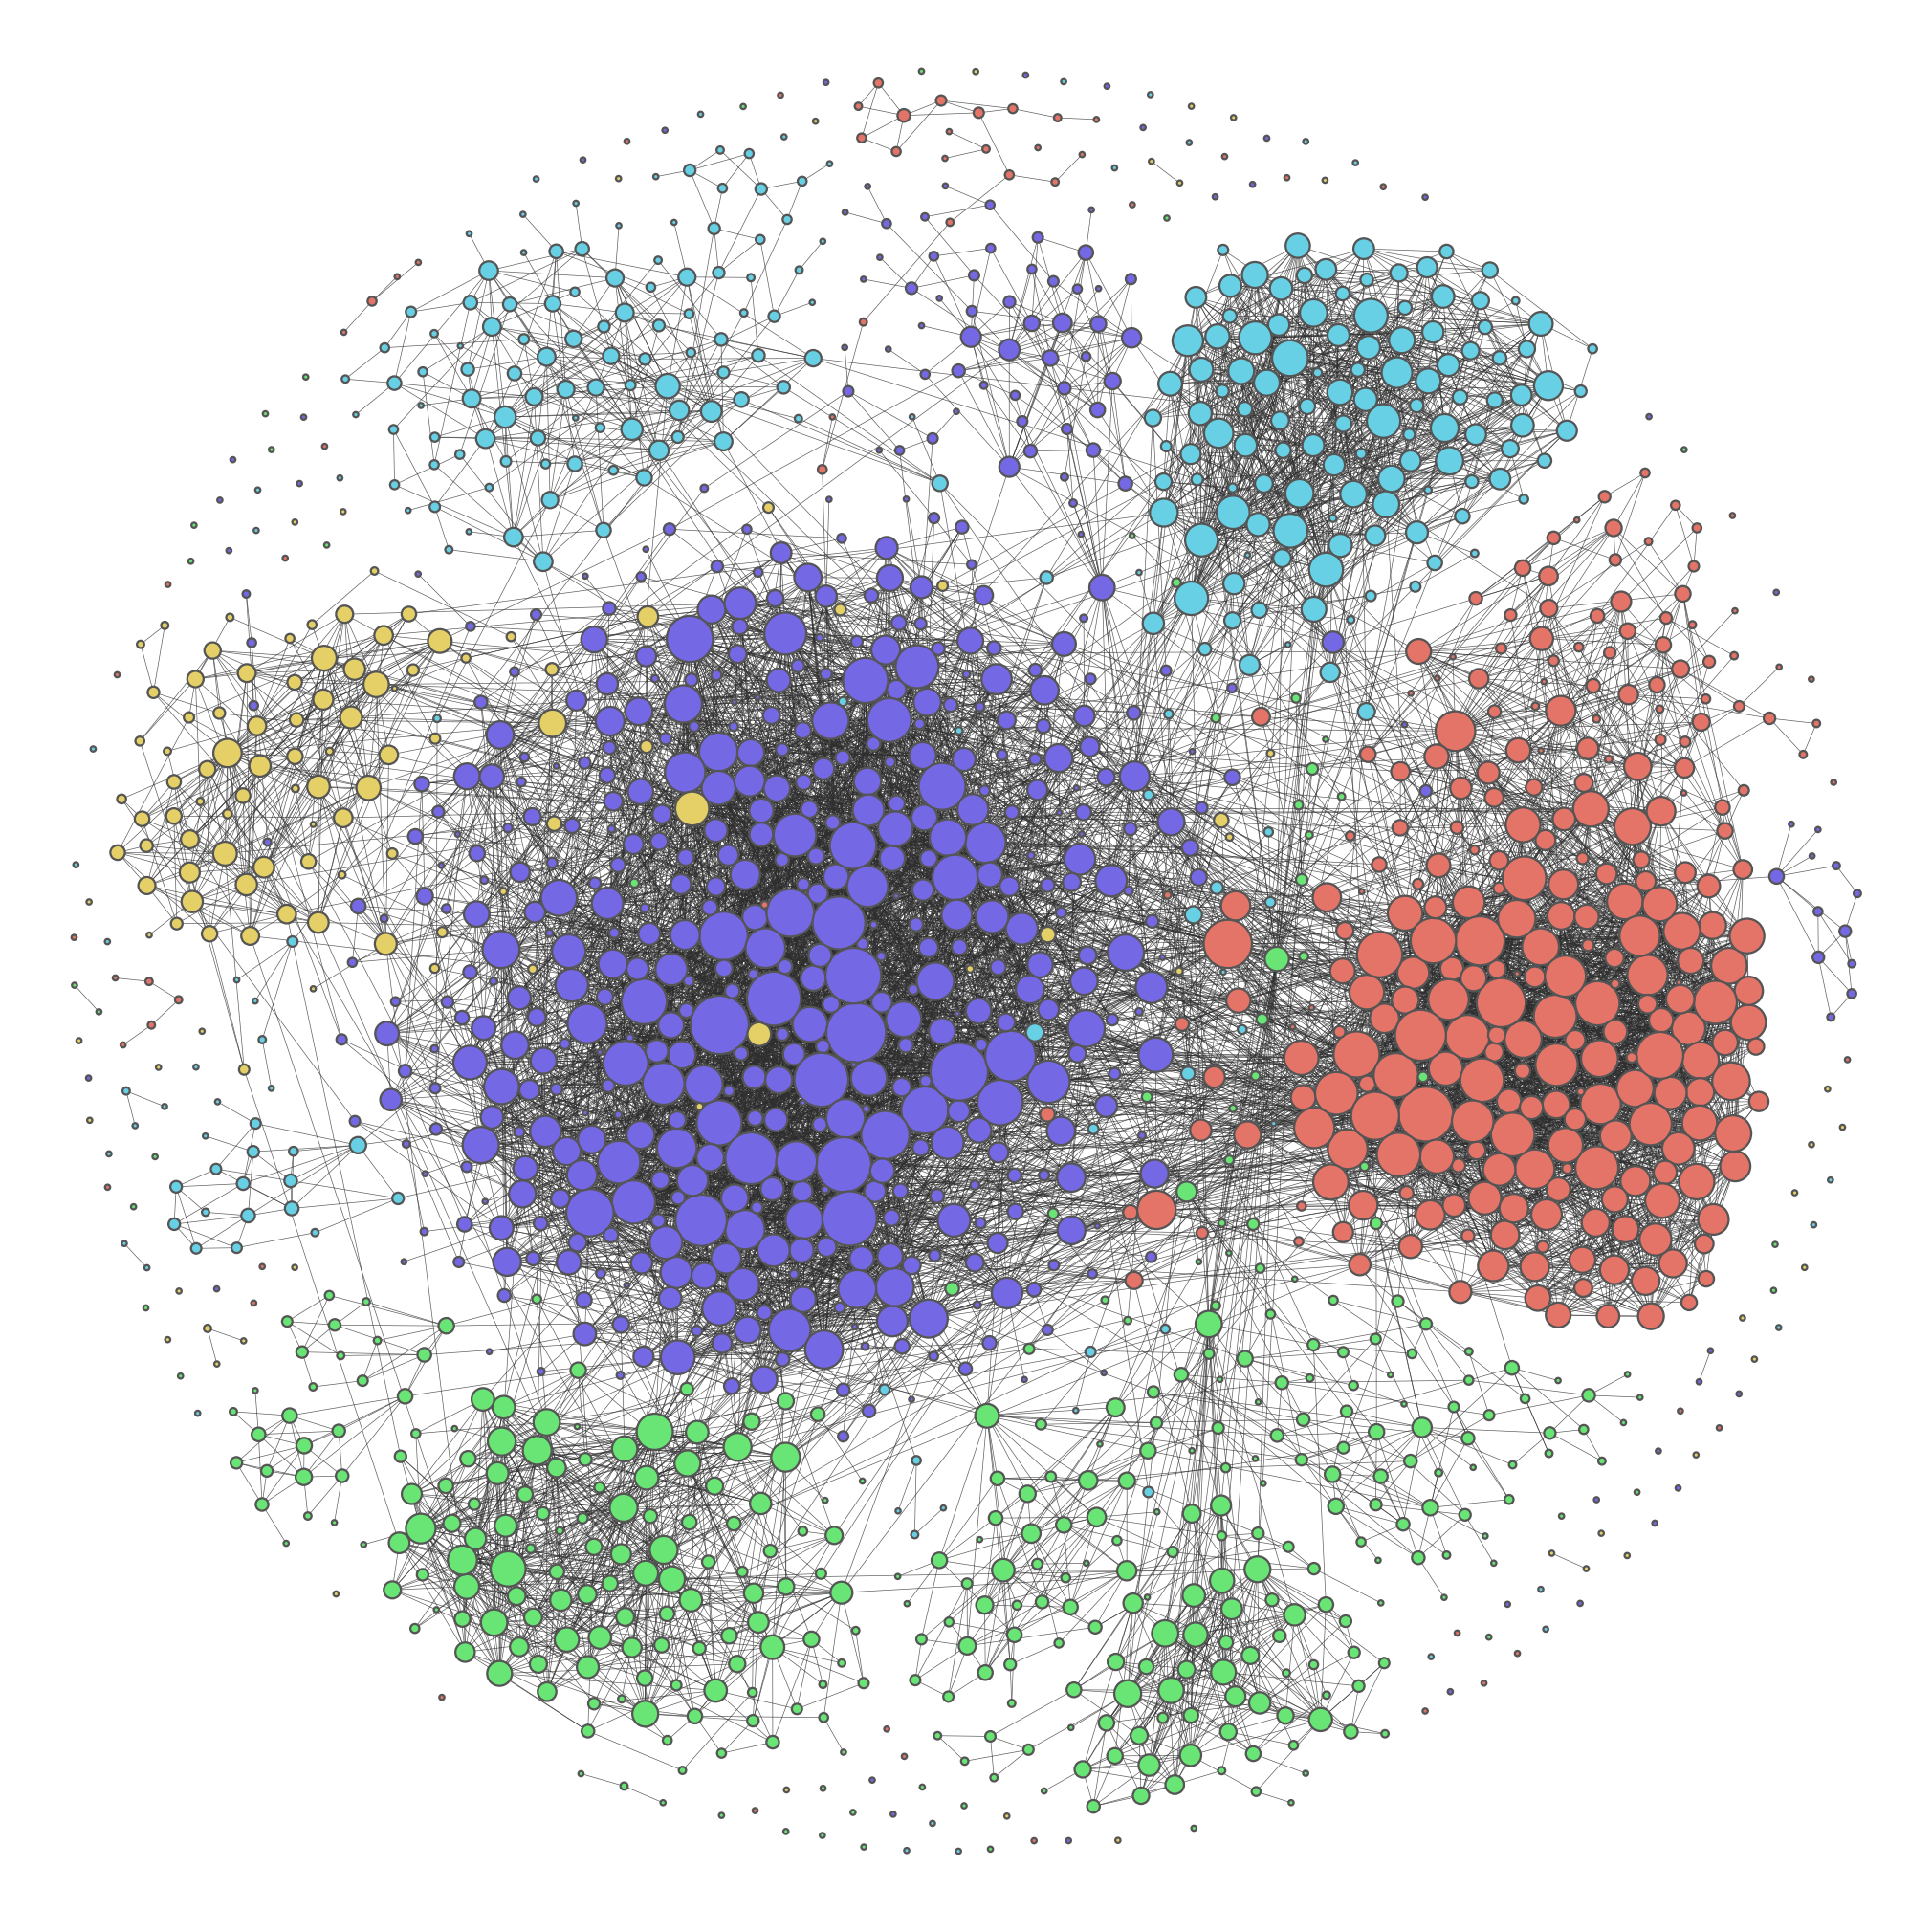

Graph with 1704 nodes and 11704 edges


In [ ]:
# Visualize rap network

from Netwulf_plot_functions import netwulf_plot_communities
from community import community_louvain 

Network_to_visualize = G_rap

communities = community_louvain.best_partition(Network_to_visualize)

colors = ['#e57468', '#68e574', '#7468e5', '#e5d068', '#68d0e5']

netwulf_plot_communities(Network_to_visualize, communities, color_palette=colors, path="Rap.pdf")